# VAE



## Libraries


In [444]:
import numpy as np                              # Numpy
import tensorflow as tf                         # Tensorflow
from tensorflow import keras                    # Keras
from tensorflow.keras import layers             # Layers
import matplotlib.pyplot as plt                 # Plot

## Sampling Layer


In [445]:
class Sampling(layers.Layer):                               # Sampling class
 
    def call(self, inputs):                                 # Uses mean and log of standard deviation to sample 'Z'
        M, V = inputs                                       # Mean and log of variance
        B = tf.shape(M)[0]                                  # Batch
        D = tf.shape(M)[1]                                  # Dimention
        E = tf.keras.backend.random_normal(shape=(B, D))    # Epsilon
        return M + tf.exp(0.5 * V) * E                      # Return the sample

## Encoder


In [446]:
DL = 2                                                      # Latent vector dimention

I = keras.Input(shape=(28, 28, 1), name="Input")            # Input
X = layers.Flatten(name="Flatten")(I)                       # Flattened input
X = layers.Dense(256, activation="relu", name="H1")(X)      # First hidden layer
X = layers.Dense(256, activation="relu", name="H2")(X)      # Second hidden layer
M = layers.Dense(DL, name="Mean")(X)                        # Mean Layer
V = layers.Dense(DL, name="Variance")(X)                    # Variance Layer
Z = Sampling(name="Sampling")([M, V])                       # Sampling Layer
encoder = keras.Model(I, [M, V, Z], name="ENCODER")         # Encoder Model
encoder.summary()                                           # Printing the computational graph

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Flatten (Flatten)               (None, 784)          0           Input[0][0]                      
__________________________________________________________________________________________________
H1 (Dense)                      (None, 256)          200960      Flatten[0][0]                    
__________________________________________________________________________________________________
H2 (Dense)                      (None, 256)          65792       H1[0][0]                         
____________________________________________________________________________________________

## Decoder


In [447]:
LI = keras.Input(shape=(DL,))                                           # Input from latent layer
X = layers.Dense(256, activation="relu", name="H1")(LI)                 # First hidden layer
X = layers.Dense(256, activation="relu", name="H2")(X)                  # Second hidden layer
DO = layers.Dense(784, activation="sigmoid", name="Output")(X)          # Output layer
DO = layers.Reshape((28, 28, 1), name="Reshape")(DO)                    # Reshaping the output
decoder = keras.Model(LI, DO, name="DECODER")                           # Decoder Model
decoder.summary()                                                       # Printing the computational graph

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
H1 (Dense)                   (None, 256)               768       
_________________________________________________________________
H2 (Dense)                   (None, 256)               65792     
_________________________________________________________________
Output (Dense)               (None, 784)               201488    
_________________________________________________________________
Reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


## VAE Model


In [448]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:                                                   # Record operations for gradient calculation
            M, V, Z = encoder(data)                                                       # Mean, Variance, Latent Variable
            reconstruction = decoder(Z)                                                   # Reconstruction
            RL = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))   # Reconstruction Loss
            RL *= 28 * 28                                                                 # Scale
            KLL = 1 + V - tf.square(M) - tf.exp(V)                                        # KL Divergence Loss
            KLL = tf.reduce_mean(KLL)                                                     # Compute mean across dimentions
            KLL *= -0.5                                                                   # Apply the formula
            L = RL + KLL                                                                  # Compute total loss
        grads = tape.gradient(L, self.trainable_weights)                                  # Calculate gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))                # Apply the processed gradients
        
        return {
            "L": L,                                                                       # Total Loss
            "RL": RL,                                                                     # Reconstruction Loss
            "KLL": KLL,                                                                   # KL Divergence Loss
        }

## Load Data

In [449]:
(train, _), (test, _) = keras.datasets.mnist.load_data()                  # Import dataset
mnist_train = np.expand_dims(train, -1).astype("float32") / 255           # Concatenate train and test sets
mnist_test = np.expand_dims(test, -1).astype("float32") / 255             # Normalize

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()   # Load data
x_train = np.expand_dims(x_train, -1).astype("float32") / 255             # Normalize train data
x_test = np.expand_dims(x_test, -1).astype("float32") / 255               # Normalize test data

## Random Sample From Data

In [450]:
x_sample = np.ndarray(shape=(15,28,28,1))

for i in np.arange(15):
  x_sample[i] = x_test[i,:,:,:]

## Sampled Digits Grid


In [451]:
def plot_latent(encoder, decoder):
    n = 15                                                            # Number of digits to sample from each axis
    digit_size = 28                                                   # Width and Height of the digits
    scale = 2.0                                                       # Scale                                                   
    figsize = 15                                                      # Figure Size
    figure = np.zeros((digit_size * n, digit_size * n))               # Figure
    grid_x = np.linspace(-scale, scale, n)                            # Linearly spaced X coordinates in 2D plot     
    grid_y = np.linspace(-scale, scale, n)[::-1]                      # Linearly spaced Y coordinates in 2D plot

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            ZS = np.array([[xi, yi]])                                 # Sampled Z
            XD = decoder.predict(ZS)                                  # Decoded X
            digit = XD[0].reshape(digit_size, digit_size)             # Digit      
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit                                                 # Placement in 2D Plot

    plt.figure(figsize=(figsize, figsize))                            # Figure
    start_range = digit_size // 2                                     # Start range
    end_range = n * digit_size + start_range + 1                      # End range
    pixel_range = np.arange(start_range, end_range, digit_size)       # Pixel range
    sample_range_x = np.round(grid_x, 1)                              # Sample range X
    sample_range_y = np.round(grid_y, 1)                              # Sample range Y
    plt.xticks(pixel_range, sample_range_x)                           # X ticks
    plt.yticks(pixel_range, sample_range_y)                           # Y ticks
    plt.xlabel("z[0]")                                                # X label
    plt.ylabel("z[1]")                                                # Y label
    plt.imshow(figure, cmap="Greys_r")                                # Color
    plt.show()                                                        # Show

## Latent Space Visualization


In [452]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)                              # Display 2D plot of classes in latent space
    plt.figure(figsize=(12, 10))                                      # Figure
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)                 # Scatter
    plt.colorbar()                                                    # Colorbar
    plt.xlabel("z[0]")                                                # X Label 
    plt.ylabel("z[1]")                                                # Y Label
    plt.show()                                                        # Show

(x_train, y_train), _ = keras.datasets.mnist.load_data()              # Load data
x_train = np.expand_dims(x_train, -1).astype("float32") / 255         # Normalize

## Original & Reconstructed Digits

In [453]:
def plot_comparison(encoder, decoder):
  x_sample = x_train
  x_e = encoder.predict(x_train)
  x_d = decoder.predict(x_e)
  x_reconstruct = x_d

  plt.figure(figsize=(8, 36))
  for i in range(15):
      plt.subplot(15, 2, 2*i + 1)
      plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
      plt.title("Test input")
      plt.colorbar()
      plt.subplot(15, 2, 2*i + 2)
      plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
      plt.title("Reconstruction")
      plt.colorbar()
  plt.tight_layout()

## Plotting Loss

In [454]:
def plot_loss(encoder, decoder):
  return 0

## Plotting

In [455]:
def plot(encoder, decoder):
  plot_latent(encoder, decoder)                                         # Plot Latent Space
  plot_label_clusters(encoder, decoder, x_train, y_train)               # Plot Label Clusters
  plot_comparison(encoder, decoder)                                     # Plot Original and Reconstructed Digits

## Training


469/469 [==============================] - 8s 17ms/step - L: 136.7542 - RL: 132.9804 - KLL: 3.7738
{'L': [139.74305725097656], 'RL': [135.90438842773438], 'KLL': [3.838665723800659]}
{'L': [139.74305725097656], 'RL': [135.90438842773438], 'KLL': [3.838665723800659]}


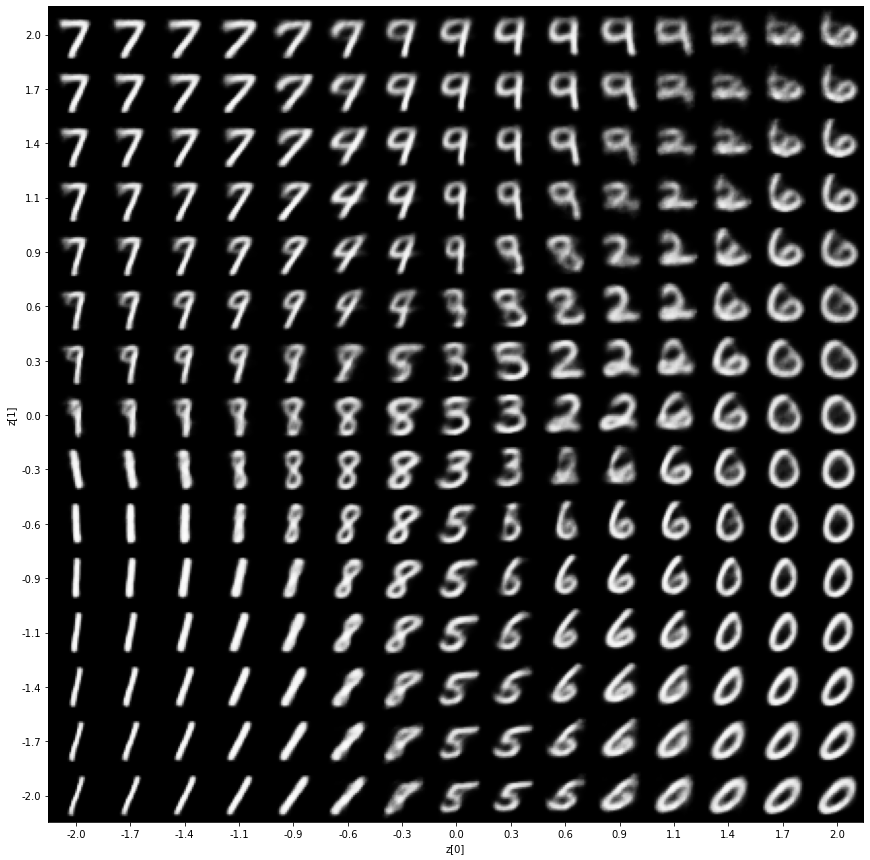

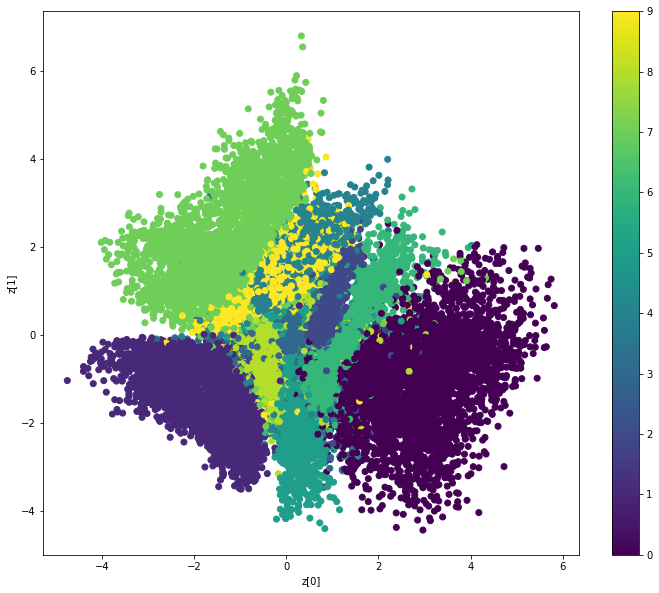

Epoch 1/4
469/469 [==============================] - 7s 16ms/step - L: 136.5599 - RL: 132.7792 - KLL: 3.7808
Epoch 2/4
469/469 [==============================] - 8s 16ms/step - L: 136.2526 - RL: 132.4746 - KLL: 3.7780
Epoch 3/4
469/469 [==============================] - 7s 16ms/step - L: 136.0854 - RL: 132.2917 - KLL: 3.7938
Epoch 4/4
469/469 [==============================] - 7s 16ms/step - L: 135.8954 - RL: 132.0998 - KLL: 3.7956
{'L': [139.74305725097656, 137.25645446777344, 132.390625, 145.42164611816406, 145.17921447753906], 'RL': [135.90438842773438, 133.44049072265625, 128.49322509765625, 141.6811065673828, 141.41883850097656], 'KLL': [3.838665723800659, 3.815969467163086, 3.8973960876464844, 3.740544557571411, 3.7603719234466553]}


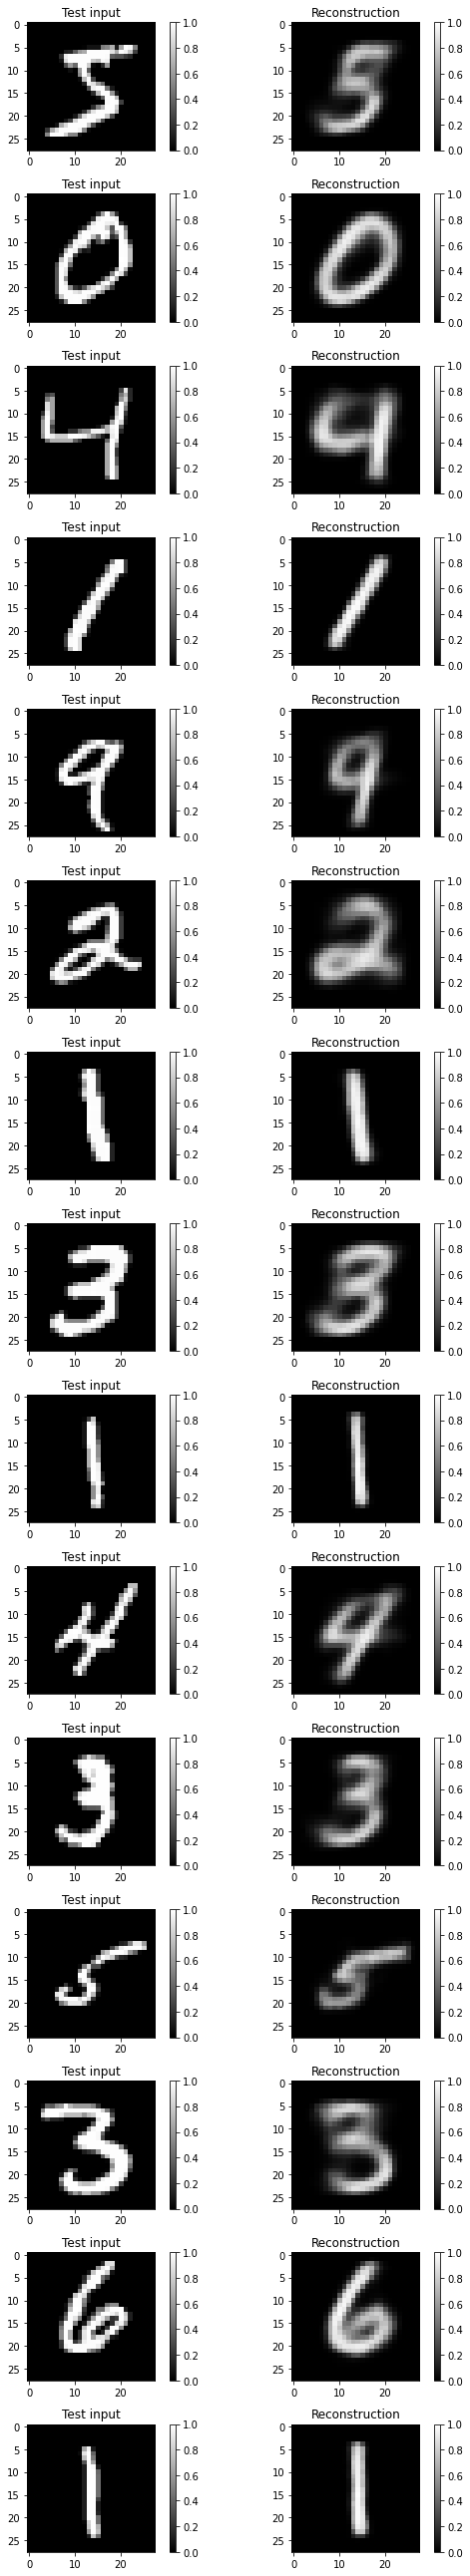

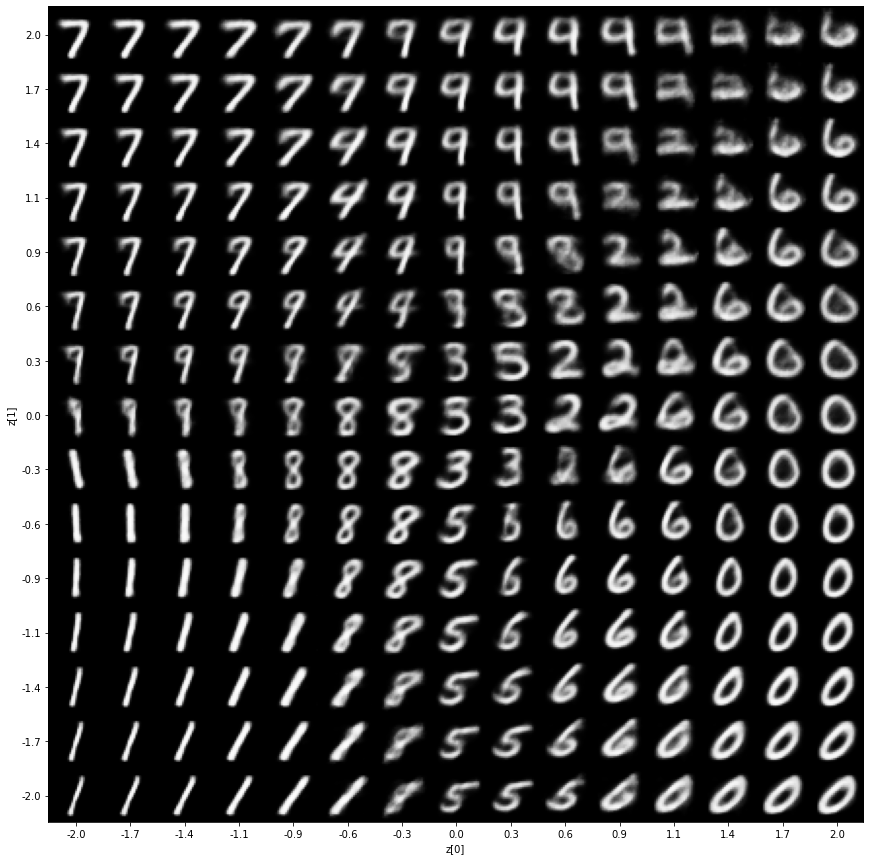

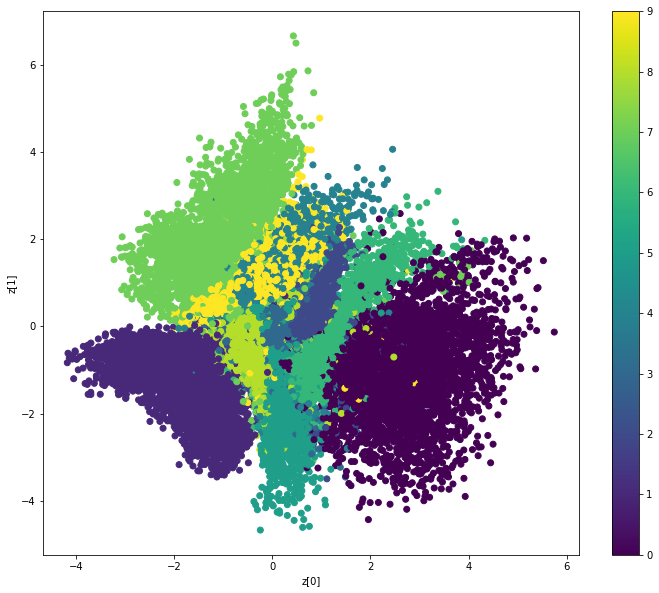

Epoch 1/20
469/469 [==============================] - 7s 16ms/step - L: 135.6705 - RL: 131.8645 - KLL: 3.8059
Epoch 2/20
469/469 [==============================] - 7s 16ms/step - L: 135.5412 - RL: 131.7366 - KLL: 3.8046
Epoch 3/20
469/469 [==============================] - 7s 16ms/step - L: 135.3919 - RL: 131.5822 - KLL: 3.8097
Epoch 4/20
469/469 [==============================] - 7s 16ms/step - L: 135.2346 - RL: 131.4150 - KLL: 3.8197
Epoch 5/20
469/469 [==============================] - 7s 16ms/step - L: 135.3021 - RL: 131.4855 - KLL: 3.8166
Epoch 6/20
469/469 [==============================] - 7s 16ms/step - L: 134.9913 - RL: 131.1576 - KLL: 3.8337
Epoch 7/20
469/469 [==============================] - 7s 16ms/step - L: 134.8519 - RL: 131.0175 - KLL: 3.8343
Epoch 8/20
469/469 [==============================] - 7s 16ms/step - L: 135.0033 - RL: 131.1721 - KLL: 3.8312
Epoch 9/20
469/469 [==============================] - 7s 16ms/step - L: 134.6799 - RL: 130.8287 - KLL: 3.8512
Epoch 10/2

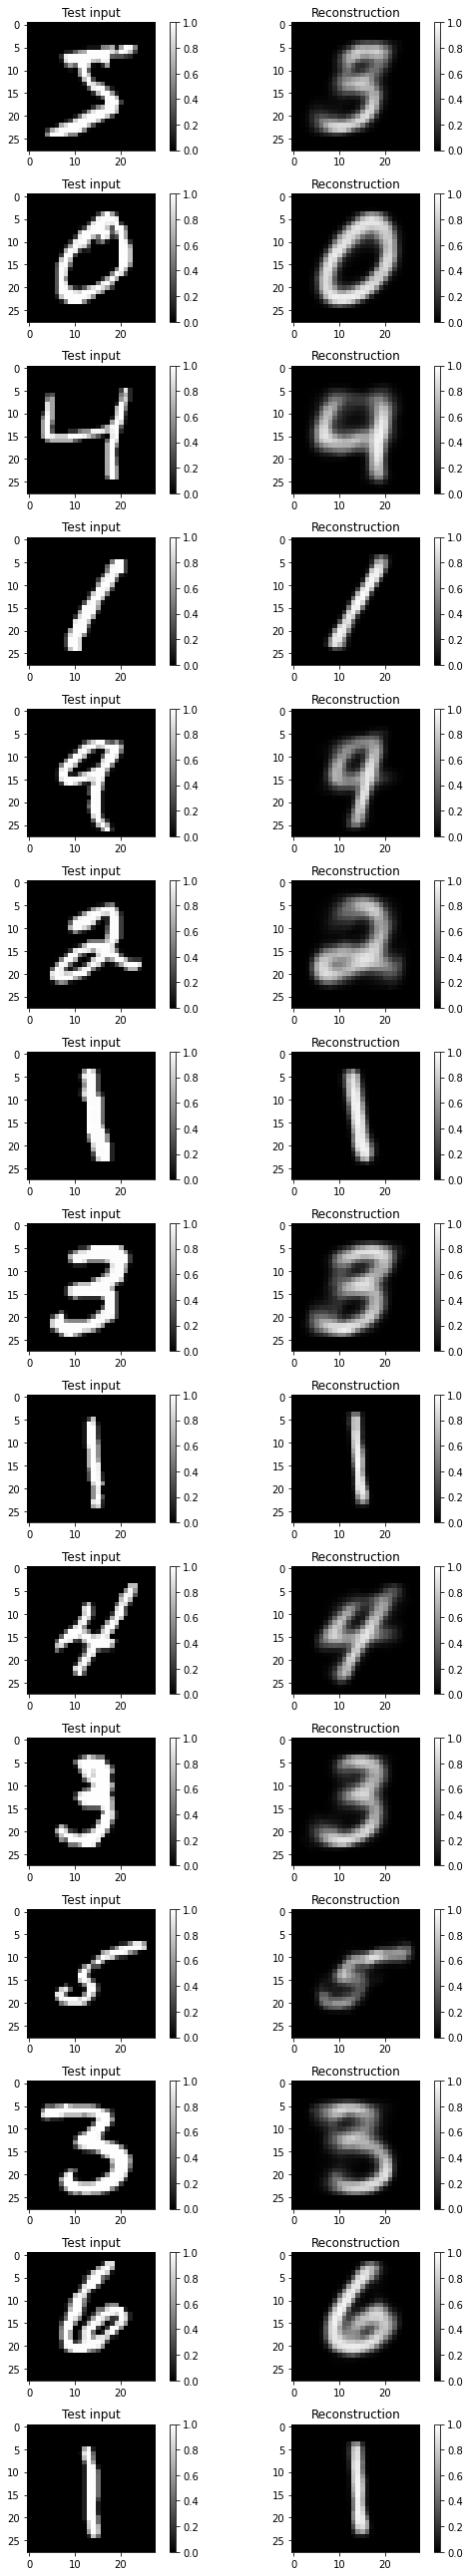

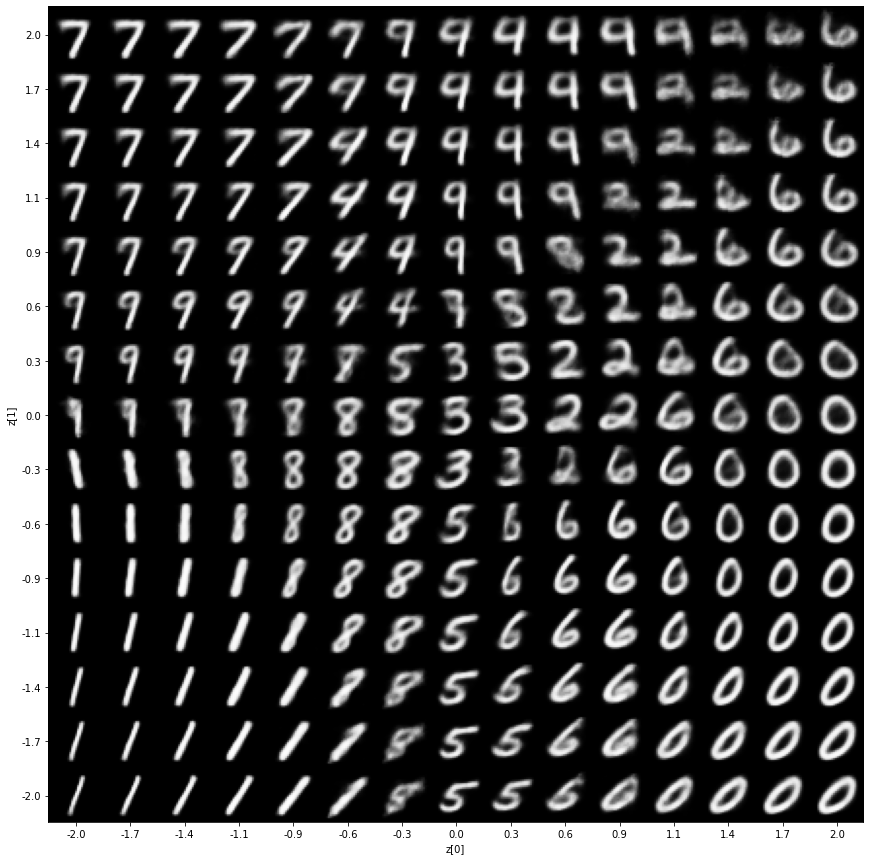

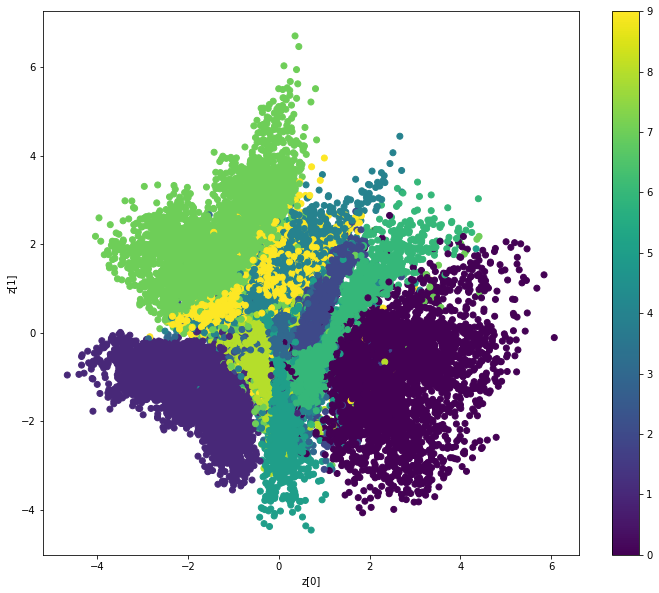

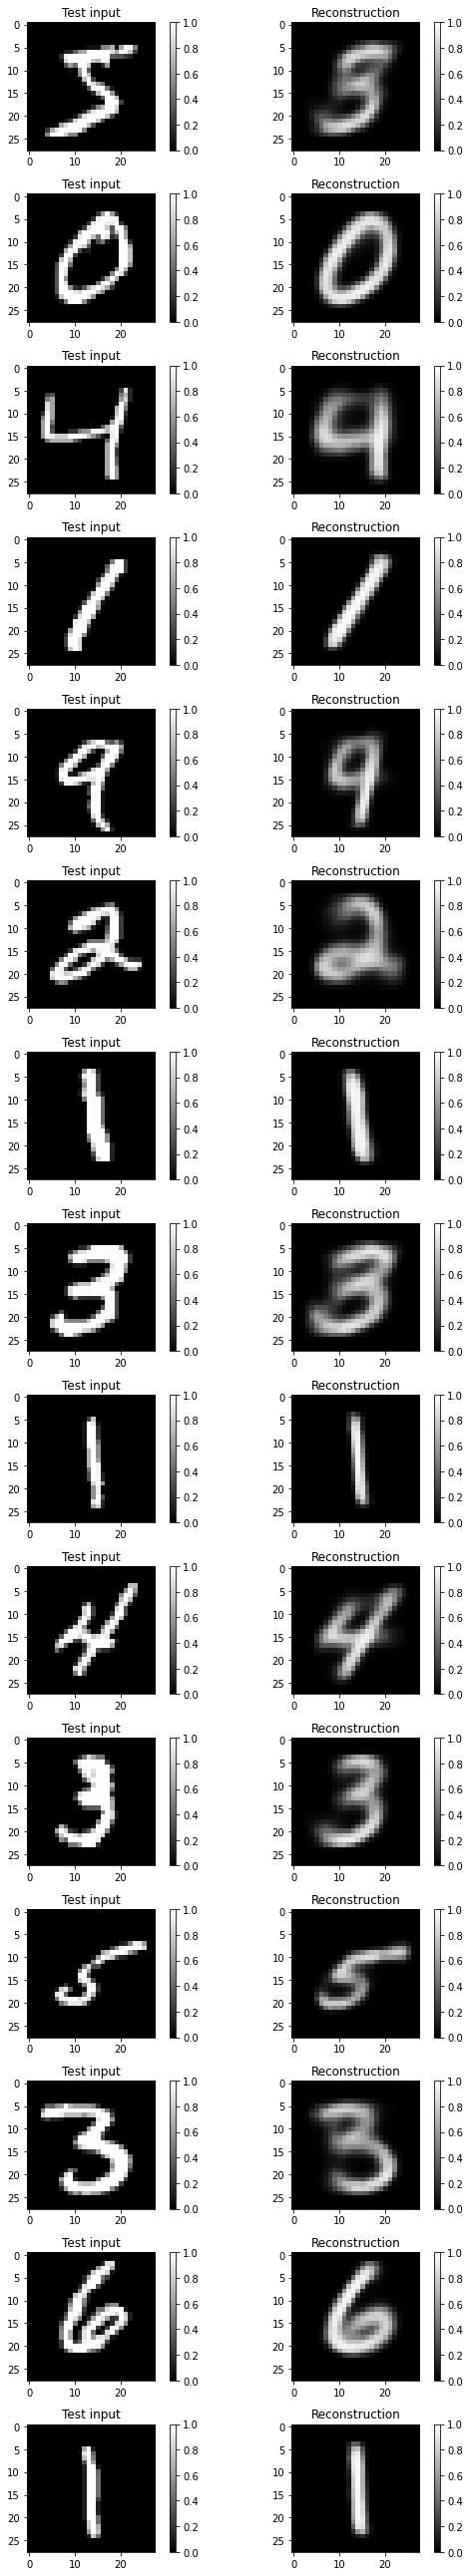

In [457]:
vae = VAE(encoder, decoder)                                             # Model of VAE
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))       # Adam optimizer with LR = 0.001

losses = {'L': [], 'RL': [], 'KLL': []}

h1 = vae.fit(mnist_train, epochs=1, batch_size=128)                      # 1 epoch trained, plotted
losses['L'].extend(h1.history['L'])
losses['RL'].extend(h1.history['RL'])
losses['KLL'].extend(h1.history['KLL'])
print(losses)
print(h1.history)                              
plot(encoder, decoder)

h2 = vae.fit(mnist_train, epochs=4, batch_size=128)                      # 5 epochs trained, plotted
losses['L'].extend(h2.history['L'])
losses['RL'].extend(h2.history['RL'])
losses['KLL'].extend(h2.history['KLL'])
print(losses)     
plot(encoder, decoder)

h3 = vae.fit(mnist_train, epochs=20, batch_size=128)                         # 25 epochs trained, plotted
losses['L'].extend(h3.history['L'])
losses['RL'].extend(h3.history['RL'])
losses['KLL'].extend(h3.history['KLL'])
print(losses)
plot(encoder, decoder)

# vae.fit(mnist_train, epochs=25, batch_size=128)                         # 50 epochs trained, plotted
# losses['L'].extend(h.history['L'])
# losses['RL'].extend(h.history['RL'])
# losses['KLL'].extend(h.history['KLL'])
# print(losses)
# plot(encoder, decoder)

# vae.fit(mnist_train, epochs=50, batch_size=128)                         # 100 epochs trained, plotted
# losses['L'].extend(h.history['L'])
# losses['RL'].extend(h.history['RL'])
# losses['KLL'].extend(h.history['KLL'])
# print(losses)
# plot(encoder, decoder)